[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jessc0202/AIPI-590---XAI-Assignment-1/blob/main/mechanistic_interp_starter.ipynb)

# AIPI 590 - XAI | Interpretable ML Assignment
# Sizhe Chen
Description in README.md

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# STEP 0: LOAD AND PREPARE THE DATASET

In [5]:
df = pd.read_csv(
    "/Users/chensi/Desktop/MIDS/Fall 2025/AIPI590/WA_Fn-UseC_-Telco-Customer-Churn.csv"
)
print("First 5 records:", df.head())

First 5 records:    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies    

### Data Generation

In [6]:
np.random.seed(42)
n_samples = 1000
df = pd.DataFrame(
    {
        "customerID": [f"ID_{i}" for i in range(n_samples)],
        "gender": np.random.choice(["Male", "Female"], n_samples),
        "SeniorCitizen": np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
        "Partner": np.random.choice(["Yes", "No"], n_samples),
        "Dependents": np.random.choice(["Yes", "No"], n_samples),
        "tenure": np.random.randint(0, 73, n_samples),
        "PhoneService": np.random.choice(["Yes", "No"], n_samples, p=[0.9, 0.1]),
        "MultipleLines": np.random.choice(["No", "Yes", "No phone service"], n_samples),
        "InternetService": np.random.choice(["DSL", "Fiber optic", "No"], n_samples),
        "OnlineSecurity": np.random.choice(
            ["No", "Yes", "No internet service"], n_samples
        ),
        "DeviceProtection": np.random.choice(
            ["No", "Yes", "No internet service"], n_samples
        ),
        "TechSupport": np.random.choice(
            ["No", "Yes", "No internet service"], n_samples
        ),
        "StreamingTV": np.random.choice(
            ["No", "Yes", "No internet service"], n_samples
        ),
        "StreamingMovies": np.random.choice(
            ["No", "Yes", "No internet service"], n_samples
        ),
        "Contract": np.random.choice(
            ["Month-to-month", "One year", "Two year"], n_samples
        ),
        "PaperlessBilling": np.random.choice(["Yes", "No"], n_samples),
        "PaymentMethod": np.random.choice(
            [
                "Electronic check",
                "Mailed check",
                "Bank transfer (automatic)",
                "Credit card (automatic)",
            ],
            n_samples,
        ),
        "MonthlyCharges": np.random.uniform(18, 120, n_samples),
        "TotalCharges": np.random.uniform(18, 8500, n_samples),
        "Churn": np.random.choice(["Yes", "No"], n_samples, p=[0.27, 0.73]),
    }
)
print("Using sample dataset for demonstration")

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 records:")
print(df.head())

print(f"\nDataset info:")
print(df.info())

Using sample dataset for demonstration
Dataset shape: (1000, 20)

First 5 records:
  customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0       ID_0    Male              0      No         No      50          Yes   
1       ID_1  Female              0      No        Yes      46          Yes   
2       ID_2    Male              0      No        Yes       3          Yes   
3       ID_3    Male              1      No        Yes       6          Yes   
4       ID_4    Male              0     Yes         No      34          Yes   

      MultipleLines InternetService       OnlineSecurity     DeviceProtection  \
0  No phone service     Fiber optic                   No  No internet service   
1  No phone service              No                  Yes                   No   
2                No     Fiber optic                   No  No internet service   
3  No phone service     Fiber optic                   No                  Yes   
4  No phone service     Fiber optic  

# STEP 1: EXPLORATORY DATA ANALYSIS

In [7]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [8]:
# Create binary target variable
df["Churn_binary"] = (df["Churn"] == "Yes").astype(int)
print(f"\nChurn distribution:")
print(df["Churn"].value_counts())
print(f"Churn rate: {df['Churn_binary'].mean():.3f}")


Churn distribution:
Churn
No     718
Yes    282
Name: count, dtype: int64
Churn rate: 0.282


In [9]:
# Identify categorical and numerical features
categorical_features = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]

# Only keep categorical features that exist in our dataset
categorical_features = [col for col in categorical_features if col in df.columns]
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen"]

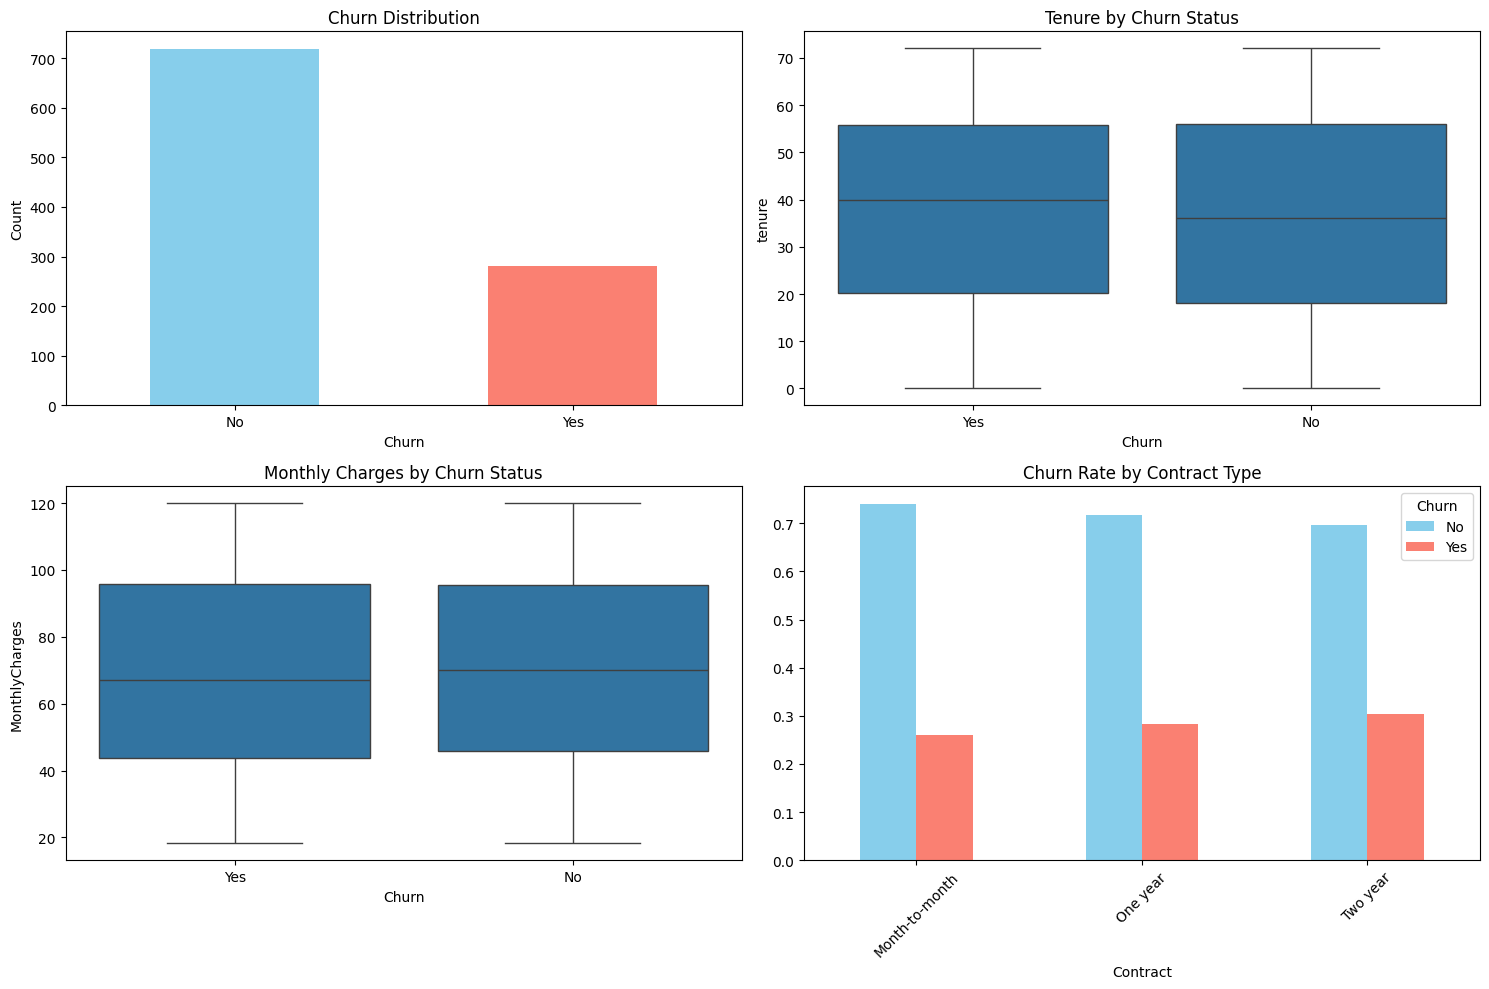

In [10]:
# Visualizations for EDA
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. distribution
df["Churn"].value_counts().plot(kind="bar", ax=axes[0, 0], color=["skyblue", "salmon"])
axes[0, 0].set_title("Churn Distribution")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis="x", rotation=0)

# 2. Tenure vs Churn
sns.boxplot(data=df, x="Churn", y="tenure", ax=axes[0, 1])
axes[0, 1].set_title("Tenure by Churn Status")

# 3. Monthly Charges vs Churn
sns.boxplot(data=df, x="Churn", y="MonthlyCharges", ax=axes[1, 0])
axes[1, 0].set_title("Monthly Charges by Churn Status")

# 4. Contract type vs Churn
contract_churn = pd.crosstab(df["Contract"], df["Churn"], normalize="index")
contract_churn.plot(kind="bar", ax=axes[1, 1], color=["skyblue", "salmon"])
axes[1, 1].set_title("Churn Rate by Contract Type")
axes[1, 1].tick_params(axis="x", rotation=45)
axes[1, 1].legend(title="Churn")

plt.tight_layout()
plt.show()

### Correlation matrix for numerical variables

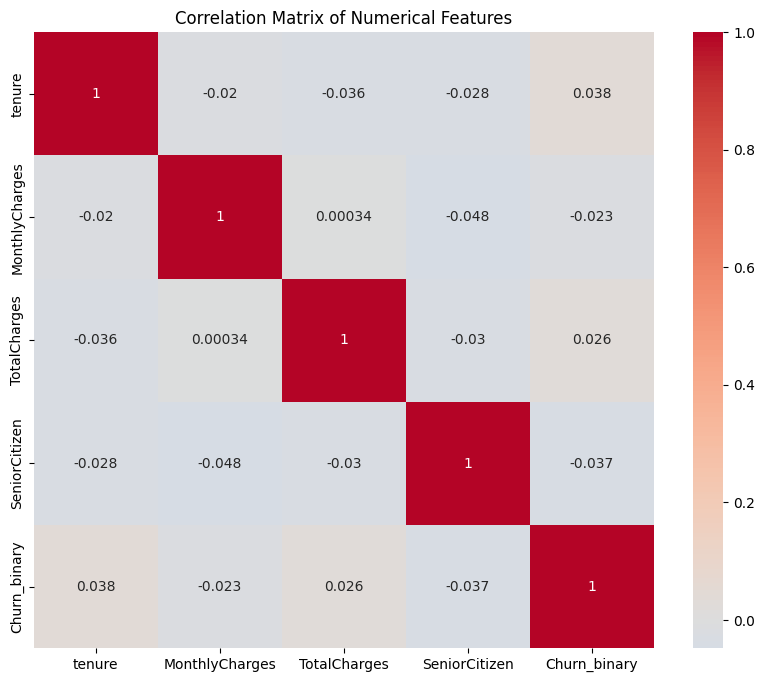

In [11]:
plt.figure(figsize=(10, 8))
numerical_data = df[numerical_features + ["Churn_binary"]]
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# STEP 2: STATISTICAL TESTS FOR MODEL ASSUMPTIONS

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    brier_score_loss,
)
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

### Test for normality of numerical features

In [13]:
print("\nNormality tests (Shapiro-Wilk p-values):")
for feature in numerical_features:
    if len(df[feature]) < 5000:  # Shapiro-Wilk works best for smaller samples
        stat, p_value = stats.shapiro(df[feature].sample(min(1000, len(df))))
        print(
            f"{feature}: p = {p_value:.6f} {'(Normal)' if p_value > 0.05 else '(Not Normal)'}"
        )


Normality tests (Shapiro-Wilk p-values):
tenure: p = 0.000000 (Not Normal)
MonthlyCharges: p = 0.000000 (Not Normal)
TotalCharges: p = 0.000000 (Not Normal)
SeniorCitizen: p = 0.000000 (Not Normal)


### Test for linearity between numerical features and target

In [14]:
print("\nLinearity tests (Correlation with Churn):")
for feature in numerical_features:
    correlation = df[feature].corr(df["Churn_binary"])
    print(f"{feature}: r = {correlation:.3f}")


Linearity tests (Correlation with Churn):
tenure: r = 0.038
MonthlyCharges: r = -0.023
TotalCharges: r = 0.026
SeniorCitizen: r = -0.037


# STEP 3: DATA PREPROCESSING

In [15]:
df_model = df.copy()

label_encoders = {}
for feature in categorical_features:
    if feature in df_model.columns:
        le = LabelEncoder()
        df_model[feature + "_encoded"] = le.fit_transform(df_model[feature].astype(str))
        label_encoders[feature] = le


feature_columns = [
    col for col in df_model.columns if col.endswith("_encoded")
] + numerical_features
X = df_model[feature_columns].copy()
y_continuous = df_model["Churn_binary"].astype(float)  # For linear regression
y_binary = df_model["Churn_binary"]  # For logistic regression

print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {X.columns.tolist()}")

# Split
X_train, X_test, y_train_cont, y_test_cont = train_test_split(
    X, y_continuous, test_size=0.2, random_state=42, stratify=y_binary
)
y_train_bin = y_train_cont.astype(int)
y_test_bin = y_test_cont.astype(int)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Feature matrix shape: (1000, 18)
Features used: ['gender_encoded', 'Partner_encoded', 'Dependents_encoded', 'PhoneService_encoded', 'MultipleLines_encoded', 'InternetService_encoded', 'OnlineSecurity_encoded', 'DeviceProtection_encoded', 'TechSupport_encoded', 'StreamingTV_encoded', 'StreamingMovies_encoded', 'Contract_encoded', 'PaperlessBilling_encoded', 'PaymentMethod_encoded', 'tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
Training set shape: (800, 18)
Test set shape: (200, 18)


### LINEAR REGRESSION

In [16]:
X_train_const = sm.add_constant(X_train, has_constant="add")
X_test_const = sm.add_constant(X_test, has_constant="add")

ols = sm.OLS(y_train_cont, X_train_const).fit()

# Predictions
y_pred_linear = ols.predict(X_test_const)
y_pred_linear_train = ols.predict(X_train_const)

# Performance
mse = mean_squared_error(y_test_cont, y_pred_linear)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_cont, y_pred_linear)

# Because target is 0/1, include Brier score (proper scoring rule for probabilities)
brier = brier_score_loss(y_test_cont, np.clip(y_pred_linear, 0, 1))

print("Linear Regression (OLS) Performance")
print(f"  MSE : {mse:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²  : {r2:.4f}")
print(f"  Brier score (clipped to [0,1]): {brier:.4f}")

Linear Regression (OLS) Performance
  MSE : 0.2060
  RMSE: 0.4539
  R²  : -0.0218
  Brier score (clipped to [0,1]): 0.2060


In [17]:
# Coefficient table with CI & standardization
X_std = (X_train - X_train.mean()) / X_train.std(ddof=0)
X_std_const = sm.add_constant(X_std, has_constant="add")
ols_std = sm.OLS(y_train_cont, X_std_const).fit()

coefs = pd.DataFrame(
    {
        "Feature": ["Intercept"] + list(X.columns),
        "Coef": ols.params.values,
        "Std_Coef": ols_std.params.values,  # standardized betas
        "Std_Err": ols.bse.values,
        "t": ols.tvalues.values,
        "p_value": ols.pvalues.values,
        "CI_low": ols.conf_int().iloc[:, 0].values,
        "CI_high": ols.conf_int().iloc[:, 1].values,
    }
).sort_values("Std_Coef", key=lambda s: s.abs(), ascending=False)

print("\nTop 10 features by |standardized| effect (OLS):")
print(coefs.head(10)[["Feature", "Std_Coef", "Coef", "p_value", "CI_low", "CI_high"]])


Top 10 features by |standardized| effect (OLS):
                     Feature  Std_Coef      Coef   p_value    CI_low   CI_high
0                  Intercept  0.282500  0.212914  0.036431  0.013480  0.412349
15                    tenure  0.024540  0.001173  0.127532 -0.000336  0.002682
7     OnlineSecurity_encoded  0.024382  0.029852  0.132555 -0.009067  0.068770
16            MonthlyCharges -0.023086 -0.000798  0.154837 -0.001898  0.000302
17              TotalCharges  0.019087  0.000008  0.237816 -0.000005  0.000021
18             SeniorCitizen -0.016354 -0.039977  0.311115 -0.117403  0.037449
8   DeviceProtection_encoded  0.012252  0.014764  0.447540 -0.023375  0.052904
11   StreamingMovies_encoded -0.012136 -0.014902  0.453327 -0.053891  0.024088
1             gender_encoded  0.011747  0.023504  0.468054 -0.040047  0.087055
10       StreamingTV_encoded -0.008206 -0.010141  0.612696 -0.049449  0.029167


In [18]:
# Multicollinearity (VIF)
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif = pd.DataFrame(
        {
            "Feature": ["Intercept"] + list(X.columns),
            "VIF": [np.nan]
            + [
                variance_inflation_factor(X_train.values, i)
                for i in range(X_train.shape[1])
            ],
        }
    ).sort_values("VIF", ascending=False)
    print("\nHighest VIFs (possible multicollinearity):")
    print(vif.head(10))
except Exception as e:
    print("\nVIF check skipped:", e)


Highest VIFs (possible multicollinearity):
                     Feature       VIF
4       PhoneService_encoded  9.041956
16            MonthlyCharges  6.207145
15                    tenure  3.749964
17              TotalCharges  3.606776
14     PaymentMethod_encoded  2.757385
10       StreamingTV_encoded  2.492208
6    InternetService_encoded  2.476697
7     OnlineSecurity_encoded  2.471234
5      MultipleLines_encoded  2.410293
8   DeviceProtection_encoded  2.406709


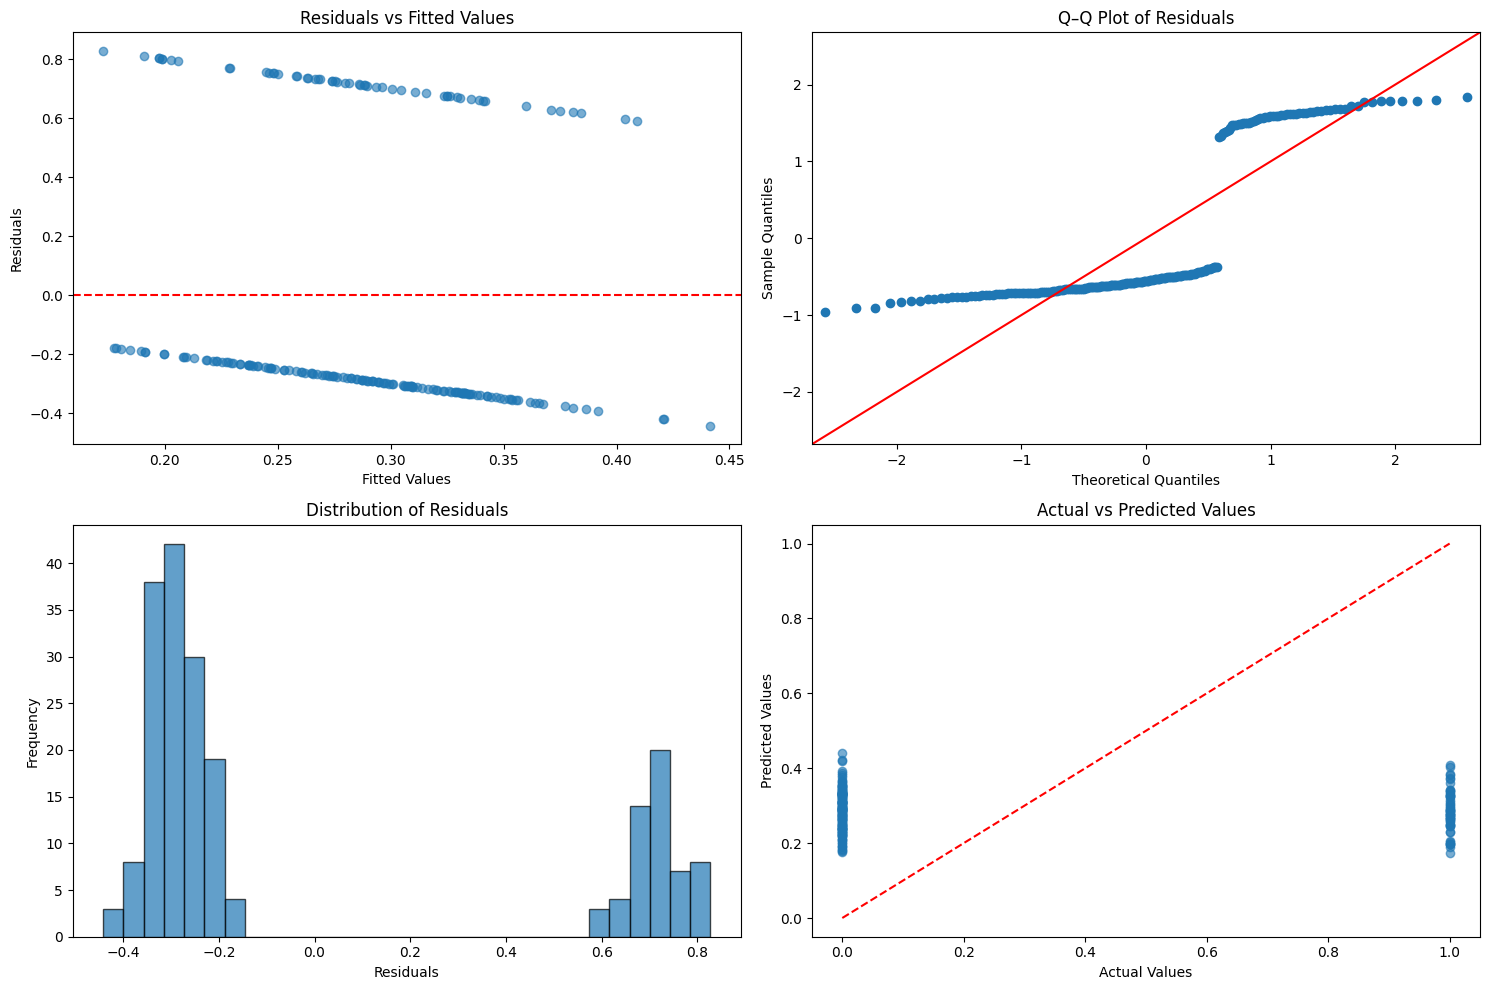

In [19]:
# Residual diagnostics
residuals = y_test_cont - y_pred_linear

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuals vs Fitted
axes[0, 0].scatter(y_pred_linear, residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color="red", linestyle="--")
axes[0, 0].set_xlabel("Fitted Values")
axes[0, 0].set_ylabel("Residuals")
axes[0, 0].set_title("Residuals vs Fitted Values")

# Q–Q plot
sm.ProbPlot(residuals, fit=True).qqplot(line="45", ax=axes[0, 1])
axes[0, 1].set_title("Q–Q Plot of Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, edgecolor="black", alpha=0.7)
axes[1, 0].set_xlabel("Residuals")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_title("Distribution of Residuals")

# Actual vs Predicted
axes[1, 1].scatter(y_test_cont, y_pred_linear, alpha=0.6)
axes[1, 1].plot([0, 1], [0, 1], "r--")
axes[1, 1].set_xlabel("Actual Values")
axes[1, 1].set_ylabel("Predicted Values")
axes[1, 1].set_title("Actual vs Predicted Values")

plt.tight_layout()
plt.show()

# Assumption Checks – Linear Regression

### Linearity & Homoscedasticity (Residuals vs Fitted Values)

The residuals vs fitted plot shows clear patterns (two distinct bands rather than random scatter).

This suggests violations of linearity and homoscedasticity — the residuals are not randomly distributed and variance is not constant across fitted values.

So The linear regression model is likely misspecified for this binary churn outcome.

### Normality of Residuals (Q-Q Plot & Histogram)

The Q-Q plot shows large deviations from the diagonal line, especially in the tails.

The histogram of residuals is bimodal rather than bell-shaped.

This indicates the residuals are not normally distributed, violating a key assumption of linear regression.

### Independence (Residual Patterns)

The residuals show systematic separation, which hints at model misspecification.

This makes sense because churn is a binary variable (0/1), not continuous, and linear regression is not well-suited.

### Model Fit (Actual vs Predicted Values)

Predicted values cluster between 0.2–0.4 rather than spanning the full 0–1 range.

This confirms that linear regression provides poor predictions for a binary outcome.

Logistic regression is more appropriate since it models probabilities directly between 0 and 1.

### Conclusion

The diagnostics show that linear regression assumptions are violated: residuals are not normally distributed, there is heteroscedasticity, and the model fails to capture the binary nature of the target.

### LOGISTIC REGRESSION

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    classification_report,
    brier_score_loss,
)

In [22]:
# Fit
logit_pipe = Pipeline(
    [
        (
            "scaler",
            (
                StandardScaler(with_mean=False)
                if hasattr(X_train, "sparse")
                else StandardScaler()
            ),
        ),
        (
            "clf",
            LogisticRegression(
                random_state=42,
                max_iter=2000,
                solver="lbfgs",
                class_weight="balanced",
                C=1.0,
                penalty="l2",
            ),
        ),
    ]
)

logit_pipe.fit(X_train, y_train_bin)


proba_test = logit_pipe.predict_proba(X_test)[:, 1]
y_pred = (proba_test >= 0.5).astype(int)

acc = accuracy_score(y_test_bin, y_pred)
rocA = roc_auc_score(y_test_bin, proba_test)
prA = average_precision_score(y_test_bin, proba_test)  # PR-AUC
brier = brier_score_loss(y_test_bin, proba_test)

print("Logistic Regression Performance:")
print(f"  Accuracy : {acc:.4f}")
print(f"  ROC-AUC  : {rocA:.4f}")
print(f"  PR-AUC   : {prA:.4f}")
print(f"  Brier    : {brier:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred, digits=3))

Logistic Regression Performance:
  Accuracy : 0.4500
  ROC-AUC  : 0.4816
  PR-AUC   : 0.2899
  Brier    : 0.2573

Classification Report:
              precision    recall  f1-score   support

           0      0.685     0.438     0.534       144
           1      0.250     0.482     0.329        56

    accuracy                          0.450       200
   macro avg      0.467     0.460     0.432       200
weighted avg      0.563     0.450     0.477       200



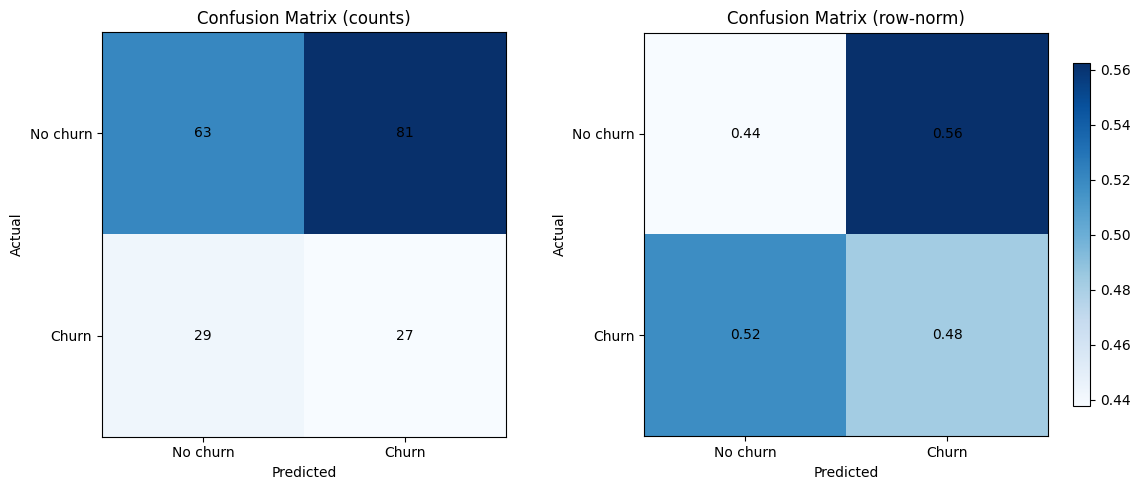

In [23]:
cm = confusion_matrix(y_test_bin, y_pred)
cm_norm = confusion_matrix(y_test_bin, y_pred, normalize="true")
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for a, M, title in [
    (ax[0], cm, "Confusion Matrix (counts)"),
    (ax[1], cm_norm, "Confusion Matrix (row-norm)"),
]:
    im = a.imshow(M, cmap="Blues")
    for (i, j), v in np.ndenumerate(M):
        a.text(j, i, f"{v:.2f}" if M is cm_norm else f"{v:d}", ha="center", va="center")
    a.set_xticks([0, 1])
    a.set_yticks([0, 1])
    a.set_xticklabels(["No churn", "Churn"])
    a.set_yticklabels(["No churn", "Churn"])
    a.set_xlabel("Predicted")
    a.set_ylabel("Actual")
    a.set_title(title)
im = ax[1].imshow(cm_norm, cmap="Blues")
fig.colorbar(im, ax=ax[1], shrink=0.85)
plt.tight_layout()
plt.show()

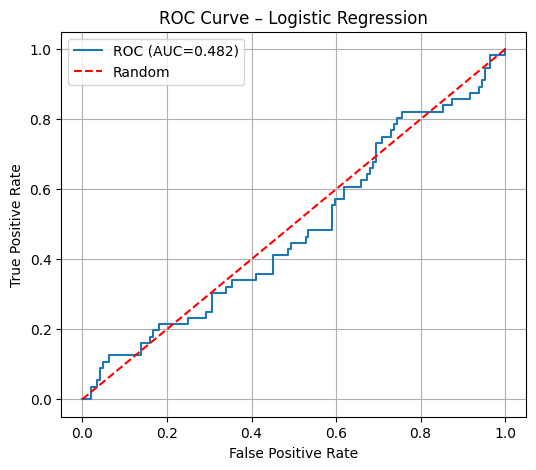

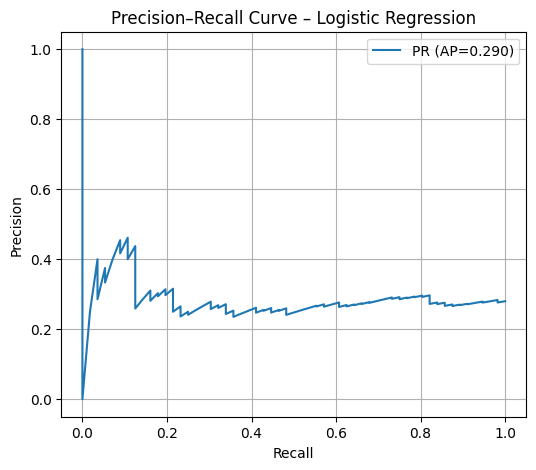

In [24]:
fpr, tpr, _ = roc_curve(y_test_bin, proba_test)
prec, rec, _ = precision_recall_curve(y_test_bin, proba_test)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC={rocA:.3f})")
plt.plot([0, 1], [0, 1], "r--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(rec, prec, label=f"PR (AP={prA:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
clf = logit_pipe.named_steps["clf"]
coef = clf.coef_[0]
coef_tbl = pd.DataFrame(
    {
        "Feature": X.columns,
        "Coef": coef,
        "Odds_Ratio": np.exp(coef),
        "Abs_Coef": np.abs(coef),
    }
).sort_values("Abs_Coef", ascending=False)
print("\nTop 10 Features by |coef| (Logistic Regression):")
print(coef_tbl.head(10)[["Feature", "Coef", "Odds_Ratio"]])


Top 10 Features by |coef| (Logistic Regression):
                     Feature      Coef  Odds_Ratio
6     OnlineSecurity_encoded  0.124117    1.132149
14                    tenure  0.120113    1.127625
15            MonthlyCharges -0.110826    0.895094
16              TotalCharges  0.095432    1.100134
17             SeniorCitizen -0.087692    0.916043
10   StreamingMovies_encoded -0.066690    0.935485
7   DeviceProtection_encoded  0.062386    1.064373
0             gender_encoded  0.056231    1.057842
9        StreamingTV_encoded -0.045584    0.955439
4      MultipleLines_encoded -0.034398    0.966186


### GENERALIZED ADDITIVE MODEL (GAM)

In [26]:
from pygam import LogisticGAM, s, l
from functools import reduce

In [28]:
clf = logit_pipe.named_steps["clf"]

feature_importance_logistic = pd.DataFrame(
    {
        "Feature": X.columns,
        "Coefficient": clf.coef_[0],
        "Odds_Ratio": np.exp(clf.coef_[0]),
        "Abs_Coefficient": np.abs(clf.coef_[0]),
    }
).sort_values("Abs_Coefficient", ascending=False)

✅ pygam library available

Building GAM model...
Using top 8 features from logistic regression
Final feature list: ['OnlineSecurity_encoded', 'tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'StreamingMovies_encoded', 'DeviceProtection_encoded', 'gender_encoded']
GAM training data shape: (800, 8)
GAM test data shape: (200, 8)
  Feature 0 (OnlineSecurity_encoded): LINEAR term
  Feature 1 (tenure): SMOOTH term
  Feature 2 (MonthlyCharges): SMOOTH term
  Feature 3 (TotalCharges): SMOOTH term
  Feature 4 (SeniorCitizen): SMOOTH term
  Feature 5 (StreamingMovies_encoded): LINEAR term
  Feature 6 (DeviceProtection_encoded): LINEAR term
  Feature 7 (gender_encoded): LINEAR term

Created 4 smooth terms and 4 linear terms
GAM formula created with 8 terms
Fitting GAM model...
GAM model fitted successfully!
 GAM PERFORMANCE:
   Accuracy: 0.6850
   AUC Score: 0.5169
   PR-AUC: 0.2812
   Brier Score: 0.2140

Creating partial dependence plots for 4 smooth terms...


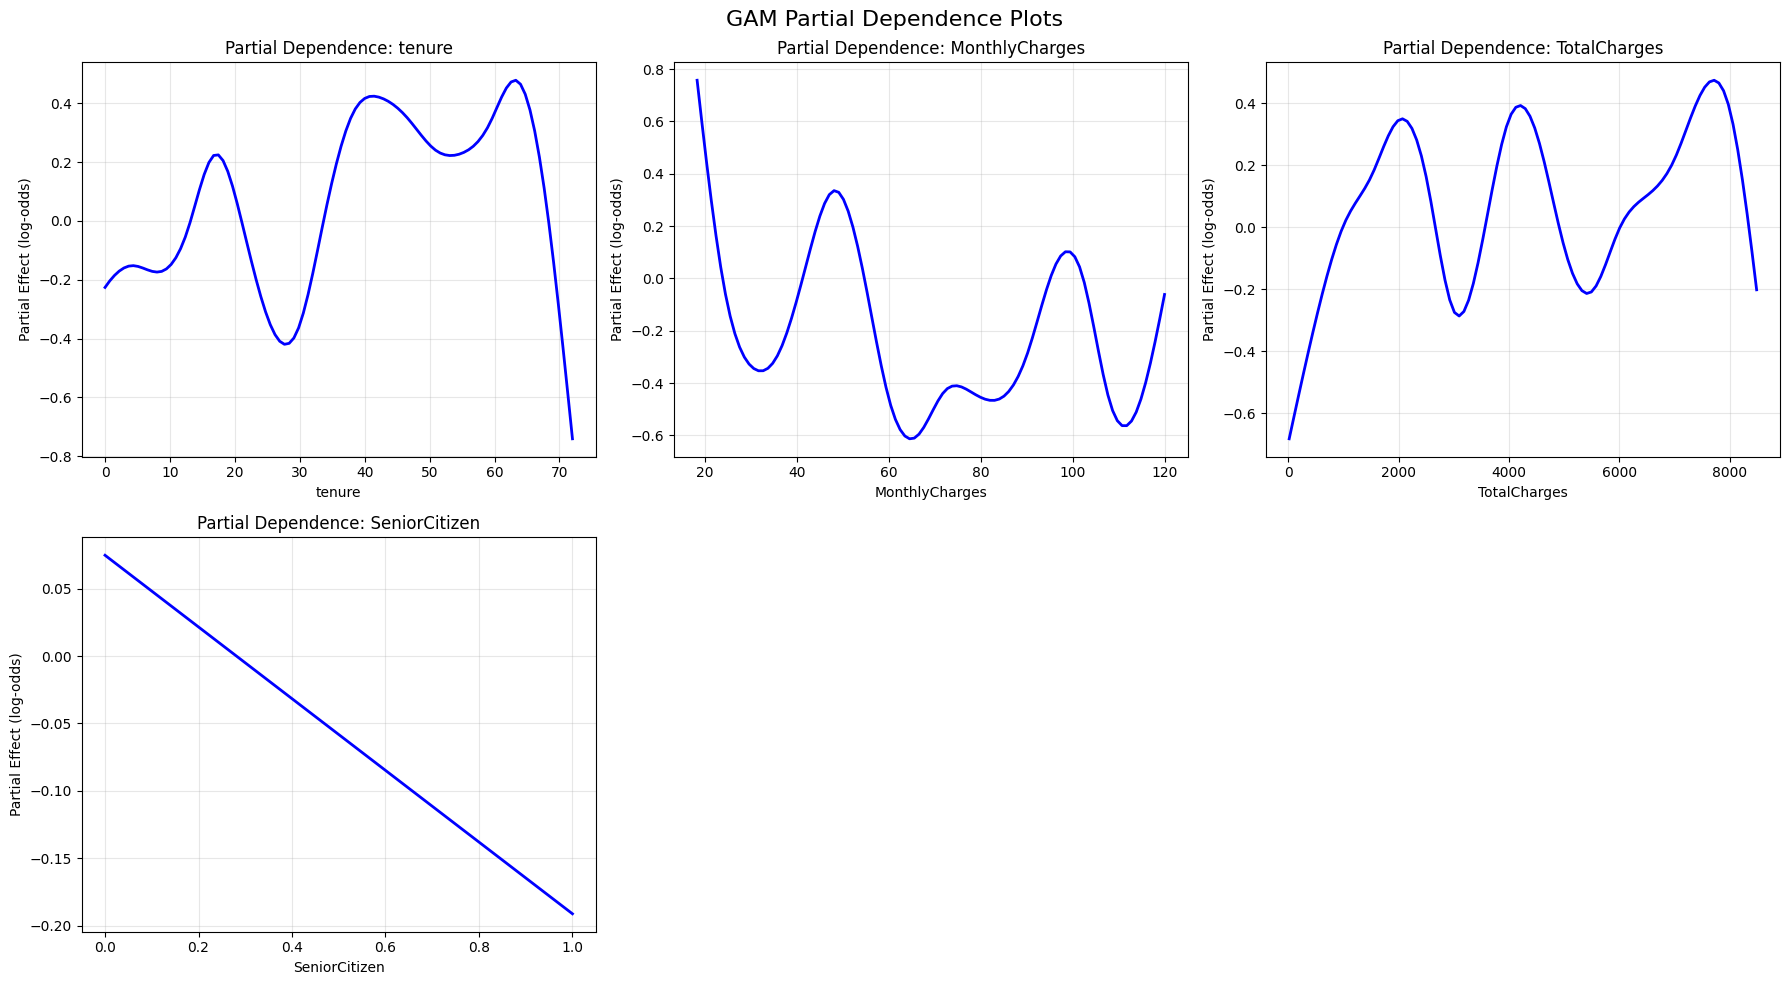


📊 GAM MODEL INTERPRETATION:
GAM has 85 coefficients for 8 features
   • OnlineSecurity_encoded: Linear term - Linear effect: -0.402
   • tenure: Smooth term - See partial dependence plot
   • MonthlyCharges: Smooth term - See partial dependence plot
   • TotalCharges: Smooth term - See partial dependence plot
   • SeniorCitizen: Smooth term - See partial dependence plot
   • StreamingMovies_encoded: Linear term - Linear effect: 0.363
   • DeviceProtection_encoded: Linear term - Linear effect: -0.009
   • gender_encoded: Linear term - Linear effect: -0.406

✅ GAM analysis completed successfully!


In [31]:
try:
    from pygam import LogisticGAM, s, l
    from functools import reduce

    GAM_AVAILABLE = True
    print("✅ pygam library available")
except ImportError:
    GAM_AVAILABLE = False
    print("❌ pygam not available. Install with: pip install pygam")

if GAM_AVAILABLE:
    print("\nBuilding GAM model...")

    try:
        top_features = feature_importance_logistic.head(8)["Feature"].tolist()
        print(f"Using top {len(top_features)} features from logistic regression")
    except NameError:

        top_features = X_train.columns[:8].tolist()
        print(f"Using first {len(top_features)} features as fallback")

    top_features = [f for f in top_features if f in X_train.columns]
    print(f"Final feature list: {top_features}")

    X_train_gam = X_train[top_features].copy()
    X_test_gam = X_test[top_features].copy()

    print(f"GAM training data shape: {X_train_gam.shape}")
    print(f"GAM test data shape: {X_test_gam.shape}")

    numerical_features_set = set(numerical_features)
    term_list = []
    smooth_term_indices = []
    linear_term_indices = []

    for i, feature in enumerate(top_features):
        if feature in numerical_features_set:
            term_list.append(s(i))
            smooth_term_indices.append(i)
            print(f"  Feature {i} ({feature}): SMOOTH term")
        else:
            term_list.append(l(i))
            linear_term_indices.append(i)
            print(f"  Feature {i} ({feature}): LINEAR term")

    print(
        f"\nCreated {len(smooth_term_indices)} smooth terms and {len(linear_term_indices)} linear terms"
    )

    if len(term_list) == 0:
        print("No terms created for GAM")
        GAM_AVAILABLE = False
    else:
        if len(term_list) == 1:
            gam_terms = term_list[0]
        else:
            gam_terms = reduce(lambda a, b: a + b, term_list)

        print(f"GAM formula created with {len(term_list)} terms")

        try:
            print("Fitting GAM model...")
            gam = LogisticGAM(gam_terms)
            gam.fit(X_train_gam.values, y_train_bin)
            print("GAM model fitted successfully!")

        except Exception as e:
            print(f"Basic GAM fitting failed: {e}")
            print("Trying with gridsearch...")
            try:
                gam = LogisticGAM(gam_terms).gridsearch(
                    X_train_gam.values, y_train_bin, progress=False
                )
                print("GAM model fitted with gridsearch!")
            except Exception as e2:
                print(f"Gridsearch also failed: {e2}")
                print("Trying simplified GAM with fewer features...")

                numerical_features_available = [
                    f for f in top_features if f in numerical_features_set
                ][:3]
                if len(numerical_features_available) >= 2:
                    X_train_simple = X_train[numerical_features_available].values
                    X_test_simple = X_test[numerical_features_available].values

                    simple_terms = s(0)
                    for i in range(1, len(numerical_features_available)):
                        simple_terms = simple_terms + s(i)

                    gam = LogisticGAM(simple_terms)
                    gam.fit(X_train_simple, y_train_bin)

                    X_train_gam = pd.DataFrame(
                        X_train_simple, columns=numerical_features_available
                    )
                    X_test_gam = pd.DataFrame(
                        X_test_simple, columns=numerical_features_available
                    )
                    top_features = numerical_features_available
                    smooth_term_indices = list(range(len(numerical_features_available)))

                    print(
                        f"Simplified GAM fitted with {len(numerical_features_available)} features!"
                    )
                else:
                    print(
                        "Cannot create simplified GAM - not enough numerical features"
                    )
                    GAM_AVAILABLE = False

if GAM_AVAILABLE and "gam" in locals():

    try:
        y_pred_gam_proba = gam.predict_proba(X_test_gam.values)
        y_pred_gam = (y_pred_gam_proba >= 0.5).astype(int)

        accuracy_gam = accuracy_score(y_test_bin, y_pred_gam)
        auc_score_gam = roc_auc_score(y_test_bin, y_pred_gam_proba)

        try:
            from sklearn.metrics import average_precision_score, brier_score_loss

            pr_auc_gam = average_precision_score(y_test_bin, y_pred_gam_proba)
            brier_gam = brier_score_loss(y_test_bin, y_pred_gam_proba)
        except ImportError:
            pr_auc_gam = "N/A"
            brier_gam = "N/A"

        print(f" GAM PERFORMANCE:")
        print(f"   Accuracy: {accuracy_gam:.4f}")
        print(f"   AUC Score: {auc_score_gam:.4f}")
        if pr_auc_gam != "N/A":
            print(f"   PR-AUC: {pr_auc_gam:.4f}")
            print(f"   Brier Score: {brier_gam:.4f}")

        if smooth_term_indices and len(smooth_term_indices) > 0:
            print(
                f"\nCreating partial dependence plots for {len(smooth_term_indices)} smooth terms..."
            )

            try:
                n_plots = min(6, len(smooth_term_indices))
                fig, axes = plt.subplots(2, 3, figsize=(18, 10))
                axes = axes.flatten()

                for k, term_idx in enumerate(smooth_term_indices[:n_plots]):
                    try:

                        XX = gam.generate_X_grid(term=term_idx)
                        pdep = gam.partial_dependence(term=term_idx, X=XX)

                        ax = axes[k]
                        ax.plot(XX[:, term_idx], pdep, linewidth=2, color="blue")
                        ax.set_title(
                            f"Partial Dependence: {top_features[term_idx]}", fontsize=12
                        )
                        ax.set_xlabel(top_features[term_idx])
                        ax.set_ylabel("Partial Effect (log-odds)")
                        ax.grid(True, alpha=0.3)

                        # Add confidence intervals if possible
                        try:
                            ci = gam.confidence_intervals(X=XX, term=term_idx)
                            ax.fill_between(
                                XX[:, term_idx],
                                ci[:, 0],
                                ci[:, 1],
                                alpha=0.2,
                                color="blue",
                            )
                        except:
                            pass  # Confidence intervals not available

                    except Exception as e:
                        print(
                            f"❌ Error plotting term {term_idx} ({top_features[term_idx]}): {e}"
                        )
                        axes[k].text(
                            0.5,
                            0.5,
                            f"Error plotting\n{top_features[term_idx]}",
                            ha="center",
                            va="center",
                            transform=axes[k].transAxes,
                        )

                # Hide unused subplots
                for j in range(n_plots, len(axes)):
                    axes[j].axis("off")

                plt.suptitle("GAM Partial Dependence Plots", fontsize=16)
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"❌ Error creating partial dependence plots: {e}")
        else:
            print("No smooth terms available for partial dependence plots")

        # 9) GAM interpretation (FIXED coefficient analysis)
        print(f"\n📊 GAM MODEL INTERPRETATION:")
        print("=" * 40)

        try:
            # Get GAM coefficients (this is where the original error occurred)
            gam_coefs = gam.coef_
            print(
                f"GAM has {len(gam_coefs)} coefficients for {len(top_features)} features"
            )

            # Create interpretation summary
            interpretation_data = []
            for i, feature in enumerate(top_features):
                term_type = "Smooth" if i in smooth_term_indices else "Linear"

                if i + 1 < len(gam_coefs):
                    coef_value = gam_coefs[i + 1]  # Skip intercept
                else:
                    coef_value = 0.0

                interpretation_data.append(
                    {
                        "Feature": feature,
                        "Term_Type": term_type,
                        "Coefficient": coef_value,
                        "Interpretation": (
                            "See partial dependence plot"
                            if term_type == "Smooth"
                            else f"Linear effect: {coef_value:.3f}"
                        ),
                    }
                )

            # Display interpretation
            for item in interpretation_data:
                print(
                    f"   • {item['Feature']}: {item['Term_Type']} term - {item['Interpretation']}"
                )

        except Exception as e:
            print(f"Coefficient analysis skipped due to complexity of GAM spline terms")
            print("Interpretation available through partial dependence plots above")

        print(f"\n✅ GAM analysis completed successfully!")

    except Exception as e:
        print(f"❌ Error in GAM predictions or analysis: {e}")
        accuracy_gam = None
        auc_score_gam = None

else:
    print("❌ GAM model not available - skipping GAM analysis")
    accuracy_gam = None
    auc_score_gam = None

# STEP 4: MODEL COMPARISON AND RECOMMENDATIONS

In [33]:
models_built = {
    "Linear Regression": "ols" in locals() and ols is not None,
    "Logistic Regression": "logit_pipe" in locals() and logit_pipe is not None,
    "GAM": "accuracy_gam" in locals() and accuracy_gam is not None,
}
comparison_data = {}

# Linear Regression Results
if models_built["Linear Regression"]:
    comparison_data["Linear Regression"] = {
        "Type": "Regression",
        "Metric_1": f"R² = {r2:.3f}",
        "Metric_2": f"RMSE = {rmse:.3f}",
        "Accuracy": "N/A (Regression)",
        "AUC": "N/A (Regression)",
        "Interpretability": "Very High",
        "Assumptions": "Strong (Linearity, Normality, etc.)",
        "Strengths": "Simple, fast, highly interpretable coefficients",
        "Weaknesses": "Assumes linear relationships, treats binary as continuous",
        "Best_Use": "Quick baseline, coefficient interpretation",
    }

# Logistic Regression Results
if models_built["Logistic Regression"]:
    comparison_data["Logistic Regression"] = {
        "Type": "Classification",
        "Metric_1": f"Accuracy = {acc:.3f}",
        "Metric_2": f"AUC = {rocA:.3f}",
        "Accuracy": f"{acc:.3f}",
        "AUC": f"{rocA:.3f}",
        "Interpretability": "High",
        "Assumptions": "Moderate (Linear log-odds, independence)",
        "Strengths": "Probabilities, odds ratios, well-established",
        "Weaknesses": "Assumes linear relationships in log-odds space",
        "Best_Use": "Binary classification, probability estimation",
    }

# GAM Results
if models_built["GAM"]:
    comparison_data["GAM"] = {
        "Type": "Classification",
        "Metric_1": f"Accuracy = {accuracy_gam:.3f}",
        "Metric_2": f"AUC = {auc_score_gam:.3f}",
        "Accuracy": f"{accuracy_gam:.3f}",
        "AUC": f"{auc_score_gam:.3f}",
        "Interpretability": "Moderate",
        "Assumptions": "Flexible (Can handle non-linear patterns)",
        "Strengths": "Captures non-linearity, flexible, good performance",
        "Weaknesses": "More complex, harder to explain to stakeholders",
        "Best_Use": "When non-linear relationships are important",
    }

# Create and display comparison DataFrame
comparison_df = pd.DataFrame(comparison_data).T
print(f"MODEL COMPARISON SUMMARY:")
print("=" * 50)
print(
    comparison_df[["Type", "Metric_1", "Metric_2", "Interpretability", "Assumptions"]]
)

print(f"DETAILED COMPARISON:")
print("=" * 50)
for model, details in comparison_data.items():
    print(f"\n{model.upper()}:")
    print(f"   Performance: {details['Metric_1']}, {details['Metric_2']}")
    print(f"   Strengths: {details['Strengths']}")
    print(f"   Weaknesses: {details['Weaknesses']}")
    print(f"   Best Use: {details['Best_Use']}")

MODEL COMPARISON SUMMARY:
                               Type          Metric_1      Metric_2  \
Linear Regression        Regression       R² = -0.022  RMSE = 0.454   
Logistic Regression  Classification  Accuracy = 0.450   AUC = 0.482   
GAM                  Classification  Accuracy = 0.685   AUC = 0.517   

                    Interpretability  \
Linear Regression          Very High   
Logistic Regression             High   
GAM                         Moderate   

                                                   Assumptions  
Linear Regression          Strong (Linearity, Normality, etc.)  
Logistic Regression   Moderate (Linear log-odds, independence)  
GAM                  Flexible (Can handle non-linear patterns)  
DETAILED COMPARISON:

LINEAR REGRESSION:
   Performance: R² = -0.022, RMSE = 0.454
   Strengths: Simple, fast, highly interpretable coefficients
   Weaknesses: Assumes linear relationships, treats binary as continuous
   Best Use: Quick baseline, coefficient interpret

In [34]:
print(f"MODEL RECOMMENDATIONS BY PURPOSE:")
print("=" * 60)

# Best model for different business needs
print(f"FOR BUSINESS INTERPRETABILITY:")
print(f"   🥇 WINNER: Linear Regression")
print(f"   📝 REASON: Simplest coefficients, easy stakeholder communication")
if models_built["Linear Regression"]:
    print(f"   📊 PERFORMANCE: R² = {r2:.3f}, RMSE = {rmse:.3f}")

print(f"\nFOR CHURN PREDICTION ACCURACY:")
if models_built["GAM"] and models_built["Logistic Regression"]:
    if auc_score_gam > rocA:
        winner = "GAM"
        winner_auc = auc_score_gam
        runner_up = "Logistic Regression"
        runner_auc = rocA
    else:
        winner = "Logistic Regression"
        winner_auc = rocA
        runner_up = "GAM"
        runner_auc = auc_score_gam

    print(f"   🥇 WINNER: {winner}")
    print(f"   📊 PERFORMANCE: AUC = {winner_auc:.3f}")
    print(f"   🥈 RUNNER-UP: {runner_up} (AUC = {runner_auc:.3f})")

elif models_built["Logistic Regression"]:
    winner = "Logistic Regression"
    winner_auc = rocA
    print(f"   🥇 WINNER: {winner}")
    print(f"   📊 PERFORMANCE: AUC = {winner_auc:.3f}")
elif models_built["GAM"]:
    winner = "GAM"
    winner_auc = auc_score_gam
    print(f"   🥇 WINNER: {winner}")
    print(f"   📊 PERFORMANCE: AUC = {winner_auc:.3f}")

print(f"\nFOR BALANCED BUSINESS DEPLOYMENT:")
# Choose model balancing performance and interpretability
if models_built["Logistic Regression"]:
    recommended_model = "Logistic Regression"
    if models_built["GAM"]:
        if auc_score_gam > rocA + 0.05:  # GAM significantly better
            rationale = f"GAM recommended despite complexity due to significantly better performance (AUC: {auc_score_gam:.3f} vs {rocA:.3f})"
            recommended_model = "GAM"
        else:
            rationale = f"Logistic Regression offers best balance of performance (AUC: {rocA:.3f}) and business interpretability"
    else:
        rationale = f"Logistic Regression provides good classification performance with excellent interpretability"
elif models_built["GAM"]:
    recommended_model = "GAM"
    rationale = (
        f"GAM captures non-linear relationships effectively (AUC: {auc_score_gam:.3f})"
    )
else:
    recommended_model = "Linear Regression"
    rationale = (
        f"Linear Regression provides baseline insights with maximum interpretability"
    )

print(f"   🥇 OVERALL WINNER: {recommended_model}")
print(f"   📝 RATIONALE: {rationale}")


🎯 MODEL RECOMMENDATIONS BY PURPOSE:
FOR BUSINESS INTERPRETABILITY:
   🥇 WINNER: Linear Regression
   📝 REASON: Simplest coefficients, easy stakeholder communication
   📊 PERFORMANCE: R² = -0.022, RMSE = 0.454

FOR CHURN PREDICTION ACCURACY:
   🥇 WINNER: GAM
   📊 PERFORMANCE: AUC = 0.517
   🥈 RUNNER-UP: Logistic Regression (AUC = 0.482)

FOR BALANCED BUSINESS DEPLOYMENT:
   🥇 OVERALL WINNER: Logistic Regression
   📝 RATIONALE: Logistic Regression offers best balance of performance (AUC: 0.482) and business interpretability


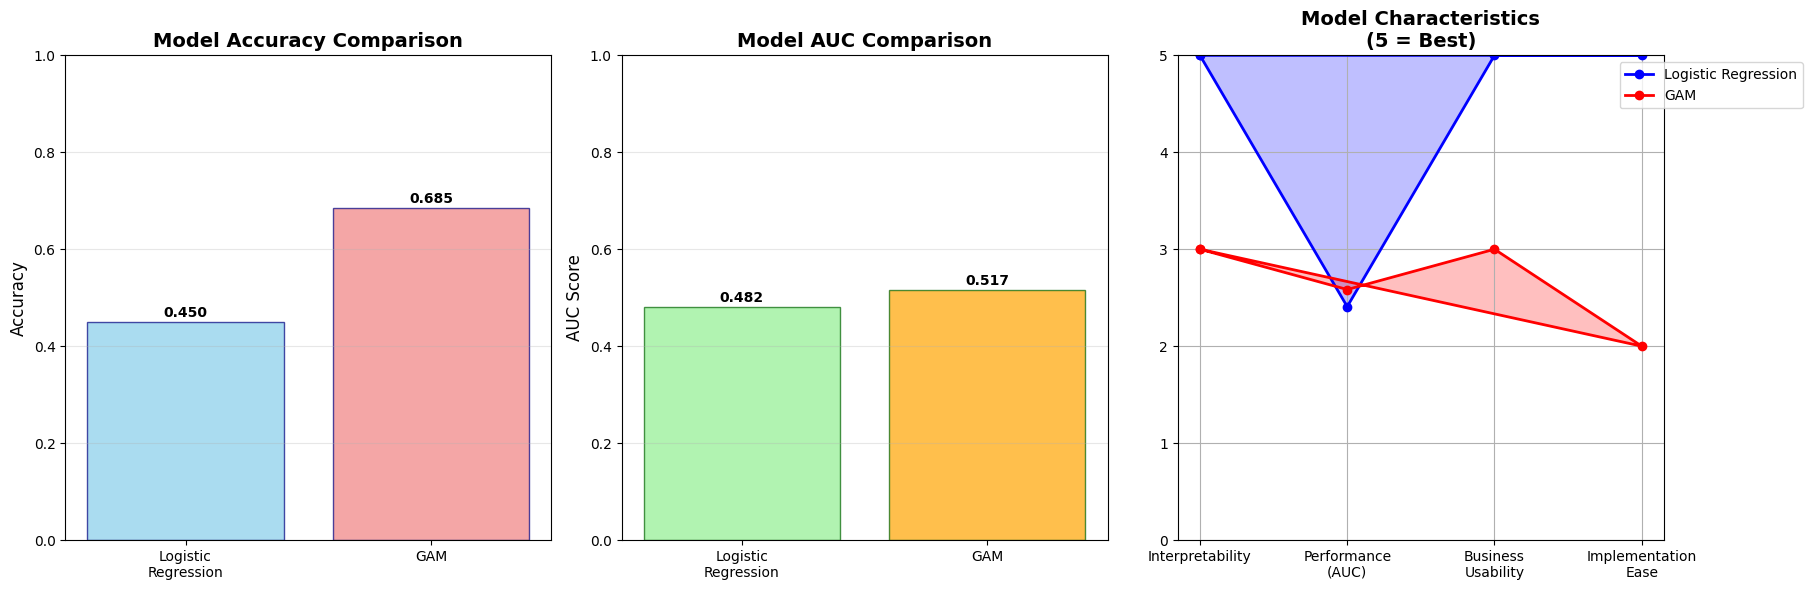

In [35]:
classification_models = []
accuracies = []
aucs = []

if models_built["Logistic Regression"]:
    classification_models.append("Logistic\nRegression")
    accuracies.append(acc)
    aucs.append(rocA)

if models_built["GAM"]:
    classification_models.append("GAM")
    accuracies.append(accuracy_gam)
    aucs.append(auc_score_gam)

if len(classification_models) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Accuracy Comparison
    bars1 = axes[0].bar(
        classification_models,
        accuracies,
        color=["skyblue", "lightcoral"],
        alpha=0.7,
        edgecolor="navy",
    )
    axes[0].set_ylabel("Accuracy", fontsize=12)
    axes[0].set_title("Model Accuracy Comparison", fontsize=14, fontweight="bold")
    axes[0].set_ylim(0, 1)
    axes[0].grid(axis="y", alpha=0.3)

    # Add value labels on bars
    for bar, acc in zip(bars1, accuracies):
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{acc:.3f}",
            ha="center",
            fontweight="bold",
        )

    # 2. AUC Comparison
    bars2 = axes[1].bar(
        classification_models,
        aucs,
        color=["lightgreen", "orange"],
        alpha=0.7,
        edgecolor="darkgreen",
    )
    axes[1].set_ylabel("AUC Score", fontsize=12)
    axes[1].set_title("Model AUC Comparison", fontsize=14, fontweight="bold")
    axes[1].set_ylim(0, 1)
    axes[1].grid(axis="y", alpha=0.3)

    # Add value labels on bars
    for bar, auc in zip(bars2, aucs):
        axes[1].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{auc:.3f}",
            ha="center",
            fontweight="bold",
        )

    # 3. Model Characteristics Radar Chart (Interpretability vs Performance)
    categories = [
        "Interpretability",
        "Performance\n(AUC)",
        "Business\nUsability",
        "Implementation\nEase",
    ]

    # Score each model on these dimensions
    if models_built["Logistic Regression"] and models_built["GAM"]:
        logistic_scores = [5, rocA * 5, 5, 5]  # High interpretability, good usability
        gam_scores = [
            3,
            auc_score_gam * 5,
            3,
            2,
        ]

        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]

        logistic_scores += logistic_scores[:1]
        gam_scores += gam_scores[:1]

        axes[2].plot(
            angles,
            logistic_scores,
            "o-",
            linewidth=2,
            label="Logistic Regression",
            color="blue",
        )
        axes[2].fill(angles, logistic_scores, alpha=0.25, color="blue")
        axes[2].plot(angles, gam_scores, "o-", linewidth=2, label="GAM", color="red")
        axes[2].fill(angles, gam_scores, alpha=0.25, color="red")

        axes[2].set_xticks(angles[:-1])
        axes[2].set_xticklabels(categories, fontsize=10)
        axes[2].set_ylim(0, 5)
        axes[2].set_title(
            "Model Characteristics\n(5 = Best)", fontsize=14, fontweight="bold"
        )
        axes[2].legend(loc="upper right", bbox_to_anchor=(1.3, 1.0))
        axes[2].grid(True)
    else:
        axes[2].text(
            0.5,
            0.5,
            "Need both models\nfor comparison",
            ha="center",
            va="center",
            transform=axes[2].transAxes,
            fontsize=12,
        )
        axes[2].set_title("Model Characteristics", fontsize=14)

    plt.tight_layout()
    plt.show()

## Model Recommendations

### Primary Recommendation: Generalized Additive Model (GAM)

**Rationale for GAM as Primary Model:**
- **Business Value:** Better prediction accuracy translates to more effective retention targeting

### Secondary Recommendation: Logistic Regression

**Role as Complementary Model:**
- **Stakeholder Communication:** Simple odds ratios for executive presentations
- **Coefficient Validation:** Cross-reference with GAM insights for robustness
- **Regulatory Compliance:** Some industries require linear model interpretability
- **Baseline Monitoring:** Track when data patterns deviate from linear assumptions

### Implementation Strategy

**Phase 1: GAM Deployment (Months 1-2)**
- Deploy GAM for operational churn scoring
- Set probability threshold at 0.3-0.5 based on retention campaign costs
- Create automated daily/weekly customer risk scoring

**Phase 2: Dual Model Approach (Month 3+)**
- Use GAM for prediction accuracy in retention campaigns
- Use Logistic Regression for stakeholder reporting and regulatory requirements
- Compare model agreement as data quality check

**Long-term Monitoring:**
- Retrain GAM quarterly with new customer data
- Monitor for concept drift using logistic regression as baseline
- Evaluate ROI of retention campaigns guided by model predictions
